# COVID-19 Prediction with Chest X-Ray

<h2 align="center">Table Of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Sorting Files</a></li>
<li><a href="#ref1">Transforms</a></li>
<li><a href="#ref2">Load Model and Finetuning</a></li>
<li><a href="#ref3">Training</a></li>
<li><a href="#ref4">Save the Model</a></li>
<li><a href="#ref5">Confusion Matrix</a></li>

In [1]:
import os
import glob
import torch
import shutil
import itertools
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

<a id="ref0"></a>
<h2 align="center">Sorting Files</h2>

The structure of the files:
1. train
    * covid
    * pneumonia
    * normal
2. test
    * covid
    * pneumonia
    * normal

In [2]:
covid_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
normal_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
pneumonia_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'

In [3]:
os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/test')

os.mkdir('/kaggle/working/train/covid')
os.mkdir('/kaggle/working/test/covid')

os.mkdir('/kaggle/working/train/normal')
os.mkdir('/kaggle/working/test/normal')

os.mkdir('/kaggle/working/train/pneumonia')
os.mkdir('/kaggle/working/test/pneumonia')

In [4]:
covid_train_len = int(np.floor(len(os.listdir(covid_path)) * 0.8))
covid_len = len(os.listdir(covid_path))

normal_train_len = int(np.floor(len(os.listdir(normal_path)) * 0.8))
normal_len = len(os.listdir(normal_path))

pneumonia_train_len = int(np.floor(len(os.listdir(pneumonia_path)) * 0.8))
pneumonia_len = len(os.listdir(pneumonia_path))

In [5]:
# loop over each class and split each up into train and test sets
# itertools.islice(seq, [start,] stop[, step]) 
# e.g. itertools.islice([1, 2, 3, 4, 5], 2) --> 1 2
# glob.glob(pathname) returns a list of path names that match pathname
# glob.iglob(pathname) returns a generator

for trainimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len):
    shutil.copy(trainimg, '/kaggle/working/train/covid')
    
for trainimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len):
    shutil.copy(trainimg, '/kaggle/working/train/normal')
    
for trainimg in itertools.islice(glob.iglob(os.path.join(pneumonia_path, '*.png')), pneumonia_train_len):
    shutil.copy(trainimg, '/kaggle/working/train/pneumonia')


for testimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len, covid_len):
    shutil.copy(testimg, '/kaggle/working/test/covid')

for testimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len, normal_len):
    shutil.copy(testimg, '/kaggle/working/test/normal')

for testimg in itertools.islice(glob.iglob(os.path.join(pneumonia_path, '*.png')), pneumonia_train_len, pneumonia_len):
    shutil.copy(testimg, '/kaggle/working/test/pneumonia')

<a id="ref1"></a>

<h2 align="center">Transforms</h2>

In [6]:
normalizer = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.25, 0.25, 0.25])

data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalizer]), 
    
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalizer])
}

In [7]:
# datasets.ImageFloder labels the images with the directory name

data_images = {
    'training': datasets.ImageFolder('/kaggle/working/train', data_transforms['training']), 
    'validation': datasets.ImageFolder('/kaggle/working/test', data_transforms['validation'])
}

In [8]:
dataloaders = {
    'training': DataLoader(data_images['training'], batch_size = 32, shuffle = True), 
    'validation': DataLoader(data_images['validation'], batch_size = 1000)
}

<a id="ref2"></a>

<h2 align="center">Load Model and Finetuning</h2>

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
for parameter in model_ft.parameters():
    parameter.requires_grad = False

model_ft.fc = nn.Sequential(
    nn.Linear(2048, 64), 
    nn.ReLU(inplace = True), 
    nn.Linear(64, 3)
).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.fc.parameters(), lr = 0.0007)

<a id="ref3"></a>

<h2 align="center">Training</h2>

In [12]:
def train_model(model, dataloaders, criterion, optimizer, n_epochs):
    
    for epoch in range(n_epochs):
        
        print('Epoch: ', str(epoch + 1) + '/' + str(n_epochs))
        
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()
            else:
                model.eval()
                
            loss_total = 0
            corrects = 0  
            for x, y in dataloaders[phase]:
                
                x = x.to(device)
                y = y.to(device)
                
                z = model(x)
                loss = criterion(z, y)
                
                if phase == 'training':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                yhat = torch.argmax(z, 1)
                loss_total += loss.item() * x.size(0)
                corrects += (yhat == y).sum().item()
                
            epoch_loss = loss_total / len(data_images[phase])
            epoch_acc = corrects / len(data_images[phase])
            
            if phase =='training':
                print(phase, 'loss:  ', format(epoch_loss, '.5f'), ' | ', phase, 'accuracy:  ', format(epoch_acc, '.5f'))
            else:
                print(phase, 'loss:', format(epoch_loss, '.5f'), ' | ', phase, 'accuracy:', format(epoch_acc, '.5f'))
                print('-' * 60)
                
                if epoch_acc >= 0.945:
                    print('Performance condition satisfied, knocking off...')
                    return model
                    
    return model

In [13]:
%%time
model = train_model(model_ft, dataloaders, criterion, optimizer, 10)

Epoch:  1/10
training loss:   0.41573  |  training accuracy:   0.83005
validation loss: 0.29784  |  validation accuracy: 0.89017
------------------------------------------------------------
Epoch:  2/10
training loss:   0.26281  |  training accuracy:   0.90100
validation loss: 0.25699  |  validation accuracy: 0.90468
------------------------------------------------------------
Epoch:  3/10
training loss:   0.24423  |  training accuracy:   0.90405
validation loss: 0.19743  |  validation accuracy: 0.92480
------------------------------------------------------------
Epoch:  4/10
training loss:   0.22456  |  training accuracy:   0.91766
validation loss: 0.20308  |  validation accuracy: 0.92018
------------------------------------------------------------
Epoch:  5/10
training loss:   0.22133  |  training accuracy:   0.91387
validation loss: 0.23387  |  validation accuracy: 0.90732
------------------------------------------------------------
Epoch:  6/10
training loss:   0.22928  |  training

<a id="ref4"></a>

<h2 align="center">Save the Model</h2>

In [14]:
import pickle
filename = 'covid_model.pickle'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

<a id="ref5"></a>

<h2 align="center">Confusion Matrix</h2>

In [15]:
labels = torch.tensor([])
preds = torch.tensor([])

with torch.no_grad():
    for x, y in dataloaders['training']:
        z = loaded_model(x)
        yhat = torch.argmax(z, 1)
        labels = torch.cat((y, labels), 0)
        preds = torch.cat((yhat, preds), 0)
        
stacked = torch.stack((labels, preds), dim = 1)
stacked

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        ...,
        [0., 0.],
        [1., 1.],
        [1., 1.]])

In [16]:
cmt = torch.zeros(3, 3, dtype = torch.int32)
cmt

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int32)

In [17]:
for p in stacked:
    j, k = p.tolist()
    j, k = int(j), int(k)
    cmt[j, k] += 1
cmt

tensor([[2765,  120,    7],
        [ 601, 7486,   66],
        [  14,   42, 1020]], dtype=torch.int32)

In [18]:
def plot_confusion_matrix(cm, classes, title = 'Confusion Matrix', cmap = plt.cm.Blues):

    print(cm)
    plt.imshow(cm, cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")
    
    plt.subplots_adjust(left = 0.15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('covid_confusion_matrix.png')

tensor([[2765,  120,    7],
        [ 601, 7486,   66],
        [  14,   42, 1020]], dtype=torch.int32)


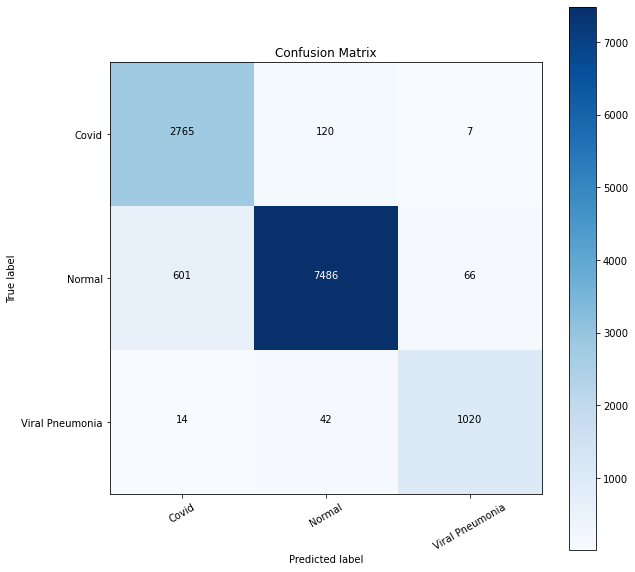

In [19]:
classes = ['Covid', 'Normal', 'Viral Pneumonia']
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cmt, classes)

In [20]:
covid_sensitivity = (cmt[0][0] / cmt[0].sum()).item()
covid_sensitivity

0.956085741519928